# Initialisation

In [1]:
import sys
sys.path.append(r'C:\Users\alexi\OneDrive\Bureau\PFE')
from dslib import *
import xarray as xr
from pathlib import Path
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import cv2
from concurrent.futures import ThreadPoolExecutor
from scipy import *
import os
import soundfile as sf
from scipy import signal
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import EarlyStopping

# IA

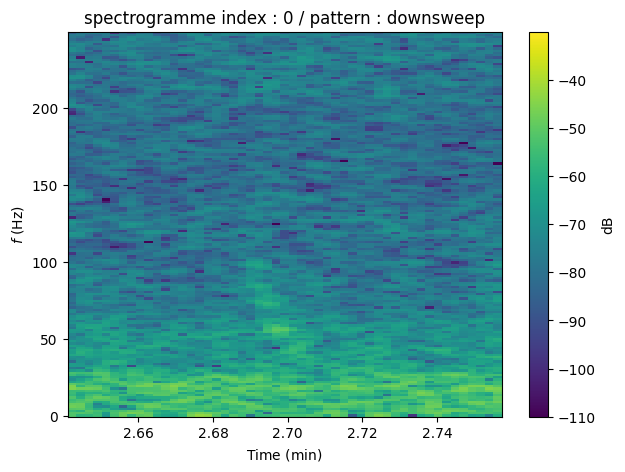

2197

In [31]:
data_path = Path(r"D:\3501\spectrograms")
data_name = [f.name for f in data_path.iterdir() if f.is_file()]
file_name = data_name[3]
f, t, spec, p, ds = open_ds(str(data_path) + '/'+file_name, index= 0, display = True)
ds.time.size

In [33]:
M = -30
m = -110
def work(file_name):
    ds = xr.open_dataset(str(data_path) + '/'+file_name)
    n = ds.index.size
    for i in range(n):
        f, t, spec, p, _ = open_ds(str(data_path) + '/'+file_name, index= i)
        if snr_test(spec, limit = -50):
            tab = 20*np.log10(np.abs(spec))
            tab = np.flipud(tab)
            tab = (tab-m)*(255)/(M-m)
            if p == 'downsweep':
                cv2.imwrite(r'C:\Users\alexi\OneDrive\Bureau\PFE\data\3501\downsweep\\'+file_name[:-5]+str(i).zfill(2)+".png", tab)
            if p == "upsweep":
                cv2.imwrite(r'C:\Users\alexi\OneDrive\Bureau\PFE\data\3501\upsweep\\'+file_name[:-5]+str(i).zfill(2)+".png", tab)
    return

with ThreadPoolExecutor() as executor:
    executor.map(work, data_name)

In [16]:
m1 = 0
m2 = 0
data_path = Path(r"C:\Users\alexi\OneDrive\Bureau\PFE\data\3446\dataset_sorted\downsweep")
data_name = [f.name for f in data_path.iterdir() if f.is_file()]
for file_name in data_name:
    signal = cv2.imread(r"C:\Users\alexi\OneDrive\Bureau\PFE\data\3446\dataset_sorted\downsweep\\"+file_name, cv2.IMREAD_GRAYSCALE)
    if m1 < signal.shape[0]:
        m1 = signal.shape[0]
    if m2 < signal.shape[1]:
        m2 = signal.shape[1]
data_path = Path(r"C:\Users\alexi\OneDrive\Bureau\PFE\data\3446\dataset_sorted\tonal")
data_name = [f.name for f in data_path.iterdir() if f.is_file()]
for file_name in data_name:
    signal = cv2.imread(r"C:\Users\alexi\OneDrive\Bureau\PFE\data\3446\dataset_sorted\tonal\"+file_name, cv2.IMREAD_GRAYSCALE)
    if m1 < signal.shape[0]:
        m1 = signal.shape[0]
    if m2 < signal.shape[1]:
        m2 = signal.shape[1]
print(m1, m2)


SyntaxError: unterminated string literal (detected at line 14); perhaps you escaped the end quote? (984793218.py, line 14)

In [6]:
M = -100
m = 100
for file_name in data_name:
    ds = xr.open_dataset(str(data_path) + '/'+file_name)
    n = ds.index.size
    for i in range(n):
        f, t, spec, p, _ = open_ds(str(data_path) + '/'+file_name, index= i)
        if snr_test(spec, -50):
            tab = 20*np.log10(np.abs(spec))
            if np.max(tab[f>10]) > M:
                M = np.max(tab[f>10])
            if np.min(tab[f>10]) < m:
                m = np.min(tab[f>10])
print(M, m)


-10.46542985560102 -153.51612184084104


CNN

création des datasets

In [36]:
import shutil
import random

# Paramètres
source_folder = Path(r"C:\Users\alexi\OneDrive\Bureau\PFE\data_set_training_all\noise\noise_noir")  # dossier source
destination_folder = Path(r"C:\Users\alexi\OneDrive\Bureau\PFE\data_set_training\noise\noise_noir")  # dossier destination
n = 3000  # nombre de fichiers à sélectionner aléatoirement


all_files = [f for f in source_folder.rglob("*") if f.is_file()]

# Choisis n fichiers aléatoires
selected_files = random.sample(all_files, n)

# Copie les fichiers sélectionnés dans le dossier destination
# Copie les fichiers dans le dossier destination avec un nouveau nom unique
for idx, file_path in enumerate(selected_files, start=1):
    # Garde l'extension d'origine
    new_name = f"file_{idx}{file_path.suffix}"
    shutil.copy(file_path, destination_folder / new_name)

print(f"{n} fichiers ont été copiés dans {destination_folder}")

3000 fichiers ont été copiés dans C:\Users\alexi\OneDrive\Bureau\PFE\data_set_training\noise\noise_noir


In [2]:
data_dir = Path(r'C:\Users\alexi\OneDrive\Bureau\PFE\data_set_training')

batch_size = 32
img_height = 224
img_width = 224

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = val_data.class_names
print(class_names)

Found 18145 files belonging to 3 classes.
Using 14516 files for training.
Found 18145 files belonging to 3 classes.
Using 3629 files for validation.
['downsweep', 'noise', 'upsweep']


K-fold

In [30]:
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import KFold
import numpy as np

# 🔹 Paramètres
data_dir = Path(r'C:\Users\alexi\OneDrive\Bureau\PFE\data_set_training')
img_height, img_width = 224, 224
batch_size = 32
num_folds = 5

# 🔹 Récupérer tous les fichiers et labels
file_paths, labels = [], []
class_names = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])

for idx, class_name in enumerate(class_names):
    class_dir = data_dir / class_name
    for f in class_dir.iterdir():   # plus besoin de vérifier l'extension
        file_paths.append(str(f))
        labels.append(idx)

file_paths = np.array(file_paths)
labels = np.array(labels)

# 🔹 K-Fold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# 🔹 Boucle K-Fold
fold_no = 1
for train_idx, val_idx in kf.split(file_paths):
    print(f"\n🔹 Fold {fold_no}")

    # Dataset d'entraînement
    train_ds = tf.data.Dataset.from_tensor_slices((file_paths[train_idx], labels[train_idx]))
    train_ds = train_ds.map(lambda x, y: (
        tf.cast(tf.image.resize(tf.io.decode_png(tf.io.read_file(x), channels=3),
                                [img_height, img_width]), tf.float32) / 255.0,
        y
    )).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Dataset de validation
    val_ds = tf.data.Dataset.from_tensor_slices((file_paths[val_idx], labels[val_idx]))
    val_ds = val_ds.map(lambda x, y: (
        tf.cast(tf.image.resize(tf.io.decode_png(tf.io.read_file(x), channels=3),
                                [img_height, img_width]), tf.float32) / 255.0,
        y
    )).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Ici tu peux créer ton modèle, l'entraîner et l'évaluer sur val_ds
    fold_no += 1


🔹 Fold 1

🔹 Fold 2

🔹 Fold 3

🔹 Fold 4

🔹 Fold 5


definition du model

In [3]:
from tensorflow.keras import layers

batch_size = 32
img_height = 224
img_width = 224

num_classes = 3


model = tf.keras.Sequential([
    layers.Rescaling(1./255),

    layers.Conv2D(16,3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(32,3, activation='relu',  padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(64,3, activation='relu',  padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(128,3, activation='relu',  padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])



   

In [4]:
from tensorflow.keras import layers

num_classes = 3


model_bis = tf.keras.Sequential([
    layers.Rescaling(1./255),

    layers.Conv2D(16,3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(32,3, activation='relu',  padding='same'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    Activation('relu'),
    layers.Dropout(0.2),

    layers.Conv2D(64,3, activation='relu',  padding='same'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    Activation('relu'),
    layers.Dropout(0.2),

    layers.Conv2D(128,3, activation='relu',  padding='same'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    Activation('relu'),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.BatchNormalization(),
    Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

Sindecay

In [5]:
import tensorflow as tf
import math

# Définition du SinDecay
class SinDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, decay_steps, lr_min=1e-6):
        super(SinDecay, self).__init__()
        self.initial_lr = initial_lr
        self.decay_steps = decay_steps
        self.lr_min = lr_min

    def __call__(self, step):
        progress = tf.cast(step, tf.float32) / self.decay_steps
        progress = tf.minimum(progress, 1.0)
        lr = self.lr_min + 0.5 * (self.initial_lr - self.lr_min) * (1 + tf.sin(math.pi * progress))
        return lr

Exponential decay

In [5]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1,  # taux initial
    decay_steps=10000,            # combien d'étapes avant d’appliquer la décroissance
    decay_rate=0.9,               # taux de décroissance
    staircase=False               # si True → décroît par paliers au lieu d’être lisse
)

Label smoothing

In [7]:
num_classes = len(class_names)  # nombre de classes
smoothing = 0.1  # facteur de lissage

def smooth_labels(y):
    y_onehot = tf.one_hot(y, num_classes)
    return y_onehot * (1 - smoothing) + smoothing / num_classes

train_data_smooth = train_data.map(lambda x, y: (x, smooth_labels(y)))
val_data_onehot = val_data.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

entrainement du model

In [6]:
lr_schedule = SinDecay(initial_lr=0.001, decay_steps=17320, lr_min=1e-6)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'],)

logdir="logs"

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_images=True)

earlystop = EarlyStopping(
    monitor='val_loss',   # métrique surveillée ('val_accuracy' aussi possible)
    patience=40,           # nombre d’epochs sans amélioration avant d’arrêter
    restore_best_weights=True # remet les poids du meilleur modèle
)

history = model.fit( 
    train_data,
  validation_data=val_data,
  epochs=40,
  callbacks=[earlystop, tensorboard_callback]
)


Epoch 1/40


c:\Users\alexi\OneDrive\Bureau\PFE\.venv\Lib\site-packages\keras\src\callbacks\tensorboard.py:680: UserWarning: Model failed to serialize as JSON. Ignoring... Learning rate schedule 'SinDecay' must override `get_config()` in order to be serializable.
  warnings.warn(f"Model failed to serialize as JSON. Ignoring... {exc}")


KeyboardInterrupt: 

Graphique

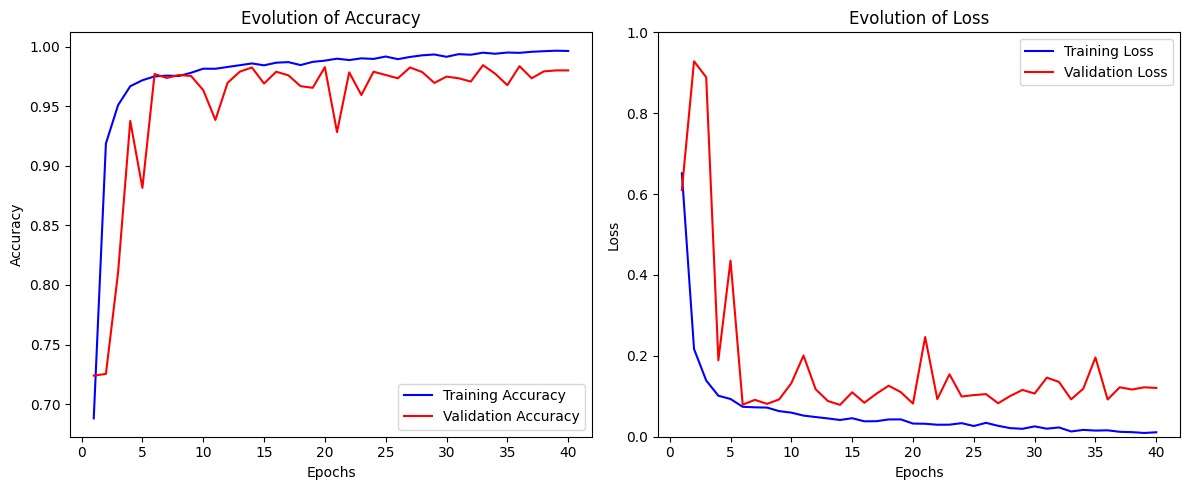

In [7]:
# Extraire les métriques de l'historique
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Tracer Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Evolution of Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Tracer Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Evolution of Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

Affichage des layers

In [9]:
#model.save_weights("C:/Users/alexi/OneDrive/Bureau/PFE/mon_modele6.weights.h5")

In [6]:
lr_schedule = SinDecay(initial_lr=0.001, decay_steps=10000, lr_min=1e-6)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.build(input_shape=(None, 224, 224, 3))
model.load_weights("C:/Users/alexi/OneDrive/Bureau/PFE/mon_modele6.weights.h5")
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [7]:
lr_schedule = SinDecay(initial_lr=0.001, decay_steps=10000, lr_min=1e-6)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_bis.build(input_shape=(None, 224, 224, 3))
model_bis.load_weights("C:/Users/alexi/OneDrive/Bureau/PFE/mon_modele5.weights.h5")
model_bis.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [ ]:
'''for images, labels in val_data.take(1):
    # images : un batch d'images
    # labels : les labels correspondants
    preds = model.predict(images)            # prédictions
    preds_classes = np.argmax(preds, axis=1) # on prend la classe prédite

    # Affichage de quelques images
    plt.figure(figsize=(12, 8))
    for i in range(min(36, images.shape[0])):  # on affiche max 9 images
        plt.subplot(6, 6, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))  # converti pour matplotlib
        plt.title(f"Vrai: {class_names[labels[i]]}\nPrédit: {class_names[preds_classes[i]]}")
        plt.axis("off")
        plt.show()

print(tf.__version__)'''

2.20.0


Definition du dataset

In [8]:
test_dir = Path(r'C:\Users\alexi\OneDrive\Bureau\PFE\test_data')
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',       # déduit les labels depuis les sous-dossiers
    label_mode='int',        # labels sous forme d'entiers
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False            # ne pas mélanger les images pour le test
)

print("Classes du test :", test_data.class_names)

Found 409 files belonging to 3 classes.
Classes du test : ['downsweep', 'noise', 'tonal']


In [133]:
'''for images, labels in test_data:
    # images : un batch d'images
    # labels : les labels correspondants
    preds = model.predict(images)            # prédictions
    preds_classes = np.argmax(preds, axis=1) # on prend la classe prédite

    # Affichage de quelques images
    plt.figure(figsize=(12, 8))
    for i in range(min(25, images.shape[0])):  # on affiche max 9 images
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))  # converti pour matplotlib
        plt.title(f"Vrai: {class_names[labels[i]]}\nPred: {class_names[preds_classes[i]]}")
        plt.axis("off")
    plt.show()'''


'for images, labels in test_data:\n    # images : un batch d\'images\n    # labels : les labels correspondants\n    preds = model.predict(images)            # prédictions\n    preds_classes = np.argmax(preds, axis=1) # on prend la classe prédite\n\n    # Affichage de quelques images\n    plt.figure(figsize=(12, 8))\n    for i in range(min(25, images.shape[0])):  # on affiche max 9 images\n        plt.subplot(5, 5, i+1)\n        plt.imshow(images[i].numpy().astype("uint8"))  # converti pour matplotlib\n        plt.title(f"Vrai: {class_names[labels[i]]}\nPred: {class_names[preds_classes[i]]}")\n        plt.axis("off")\n    plt.show()'

In [9]:
loss, accuracy = model.evaluate(test_data)
print(f"Loss sur test set : {loss:.4f}")
print(f"Accuracy sur test set : {accuracy:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9169 - loss: 0.4205
Loss sur test set : 0.4205
Accuracy sur test set : 0.9169


In [8]:
#data_path = Path(r"C:\Users\alexi\OneDrive\Bureau\mois_test")
#data_name = [f.name for f in data_path.iterdir() if f.is_file()]

def detect(file_name):
    dt_moy = []
    ut_moy = []
    audio, fs = sf.read(r"C:\Users\alexi\OneDrive\Bureau\test\\" + file_name)
    n_fft = 4096
    hop_length = n_fft*0.2
    f, t, spectro = signal.stft(audio, fs, 'hann', nperseg = n_fft, noverlap = n_fft-hop_length)
    fonc2(spectro, file_name, f, t, dt_moy, ut_moy)
    print(file_name)
    return dt_moy, ut_moy

#with ThreadPoolExecutor() as executor:
    #executor.map(work, data_name)

In [17]:
data_path = Path(r"C:\Users\alexi\OneDrive\Bureau\test")
data_names = [f.name for f in data_path.iterdir() if f.is_file()]
def work(file_name):
    detect(file_name)

with ThreadPoolExecutor() as executor:
    executor.map(work, data_names)


20150202T020001.flac
20150202T021501.flac
20150202T040002.flac
20150202T031501.flac
20150202T014501.flac
20150202T011502.flac
20150202T033001.flac
20150202T024501.flac
20150202T034501.flac
20150202T023002.flac
20150202T030002.flac
20150202T013001.flac
20150202T041501.flac
20150202T050001.flac
20150202T043002.flac
20150202T044502.flac
20150202T053002.flac
20150202T054502.flac
20150202T051501.flac
20150202T060002.flac
20150202T064501.flac
20150202T070002.flac
20150202T061510.flac
20150202T063001.flac
20150202T071502.flac
20150202T074501.flac
20150202T080002.flac
20150202T081502.flac
20150202T073001.flac
20150202T083001.flac
20150202T091502.flac
20150202T084501.flac
20150202T093002.flac
20150202T094502.flac
20150202T100001.flac
20150202T090001.flac
20150202T103002.flac
20150202T104502.flac
20150202T101501.flac
20150202T110001.flac
20150202T111502.flac
20150202T114501.flac
20150202T113002.flac
20150202T123001.flac
20150202T130001.flac
20150202T121501.flac
20150202T124502.flac
20150202T1200

In [9]:
def fonc(
        full_spec: np.ndarray,
        freq: np.ndarray,
        time: np.ndarray,
        t_moy,
        M,
        m,
):
    dt = 7
    tmin, tmax = t_moy-(dt/2), t_moy+(dt/2)
    fmin, fmax = 0, 250

    fmask = (freq >= fmin) & (freq <= fmax)
    tmask = (time >= tmin) & (time <= tmax)

    fslice = np.full_like(freq, np.nan)
    tslice = np.full_like(time, np.nan)
    fslice[np.ix_(fmask)] = np.copy(freq[np.ix_(fmask)])
    tslice[np.ix_(tmask)] = np.copy(time[np.ix_(tmask)])


    spec_data = np.full_like(full_spec, np.nan)
    spec_data[np.ix_(fmask, tmask)] = np.copy(full_spec[np.ix_(fmask, tmask)])

    
    fslice = fslice[~np.isnan(fslice)]

    tslice = tslice[~np.isnan(tslice)]

    spec_data = spec_data[~np.isnan(spec_data)].reshape(fslice.size, tslice.size)

    spec_data = 20*np.log10(np.abs(spec_data))
    spec_data = np.flipud(spec_data)
    spec_data = np.clip(spec_data, m, M)
    spec_data = (spec_data-m)*(255)/(M-m)

    return spec_data

In [11]:

class_names = val_data.class_names
print(class_names)

['downsweep', 'noise', 'upsweep']


In [10]:
img = cv2.imread(r"C:\Users\alexi\OneDrive\Bureau\PFE\test_data\downsweep\20151128T194578.png",   cv2.IMREAD_GRAYSCALE)
img = tf.image.resize(img[..., np.newaxis], (224, 224))
img = np.stack([img[:,:,0]]*3, axis=-1)
img = np.expand_dims(img, axis=0) 

TypeError: 'NoneType' object is not subscriptable

In [13]:
def fonc2(spectro, file_name, f, t, dt_moy, ut_moy):
    j = 0
    overlap = 3.5
    dt = 7
    time = np.arange(dt/2, 300-(dt/2), 7-overlap)
    for i in range(len(time)):
        img = fonc(spectro, f, t, t_moy=time[i] ,M= -30,m= -110)
        img_bis = img
        img = tf.image.resize(img[..., np.newaxis], (224, 224))
        img = np.stack([img[:,:,0]]*3, axis=-1)
        img = np.expand_dims(img, axis=0)
        preds = model.predict(img, verbose = 0)  
        preds_classes = np.argmax(preds)
        if preds_classes == 0  and np.max(preds[0][0]) > 0.9:
                preds_bis = model_bis.predict(img, verbose = 0)
                preds_classes_bis = np.argmax(preds_bis)
                if preds_classes_bis == 0  and np.max(preds_bis[0][0]) > 0.9:
                        cv2.imwrite(r"C:\Users\alexi\OneDrive\Bureau\PFE\detection\downsweep\\"+file_name[:-7]+str(j).zfill(2)+".png", img_bis)
                        j+=1
                        #dt_moy.append((i+1)*dt/2)
        if preds_classes == 2 and np.max(preds[0][2])> 0.9:
                preds_bis = model_bis.predict(img, verbose = 0)
                preds_classes_bis = np.argmax(preds_bis)
                if preds_classes_bis == 2  and np.max(preds_bis[0][2]) > 0.9:
                        cv2.imwrite(r"C:\Users\alexi\OneDrive\Bureau\PFE\detection\upsweep\\"+file_name[:-7]+str(j).zfill(2)+".png", img_bis)
                        j+=1
                        #ut_moy.append((i+1)*dt/2)
        
        
    

In [71]:
data_path = Path(r"C:\Users\alexi\OneDrive\Bureau\test")
data_names = [f.name for f in data_path.iterdir() if f.is_file()]
label_path = Path(r"C:\Users\alexi\OneDrive\Bureau\etiquettes_3382")
dlabel_path = Path(r"C:\Users\alexi\OneDrive\Bureau\downsweep_label")
ulabel_path = Path(r"C:\Users\alexi\OneDrive\Bureau\upsweep_label")
label_names = [f.name for f in label_path.iterdir() if f.is_file()]
file_names = data_names

dd = 0
dn = 0
du = 0
nd = 0
nn = 0
nu = 0
ud = 0
un = 0
uu = 0

matches_label = np.array([])
for file_name in file_names:
    dmatches, umatches = detect(file_name)
    #print('\n', file_name)
    label_name = file_name[:-4]+'txt'
    if label_name in label_names:
        ##downsweep
        with open(str(dlabel_path)+'/'+label_name) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        list_content = contents.split('\n')
        dlabel_times = np.zeros(line_count)
        for i in range(line_count):
            delta_time = list_content[2*i].split()
            tmin, tmax = float(delta_time[0]), float(delta_time[1])
            tmoy = (tmin + tmax)/2
            dlabel_times[i] = tmoy
        #print(dlabel_times)
         ##upsweep
        with open(str(ulabel_path)+'/'+label_name) as file:
            contents = file.read()
        line_count = contents.count('\n')//2
        list_content = contents.split('\n')
        ulabel_times = np.zeros(line_count)
        for i in range(line_count):
            delta_time = list_content[2*i].split()
            tmin, tmax = float(delta_time[0]), float(delta_time[1])
            tmoy = (tmin + tmax)/2
            ulabel_times[i] = tmoy
        
        
            
        epsilon = 4
        ##downsweep
        for i in range(len(dmatches)):
            t_moy = dmatches[i]
            if np.any(np.isclose(dlabel_times, t_moy, atol= epsilon)):
                matches_label = np.append(matches_label, 1)
                #print(t_moy, 'DD')
                dd+=1
            elif np.any(np.isclose(ulabel_times, t_moy, atol= epsilon)):
                matches_label = np.append(matches_label, 0)
                #print(t_moy, 'ND')
                ud+=1
            else :
                matches_label = np.append(matches_label, 0)
                #print(t_moy, 'ND')
                nd+=1
        for tlab in dlabel_times:
            if ~np.any(np.isclose(dmatches, tlab, atol= epsilon)):
                matches_label = np.append(matches_label, 1)
                #print(tlab, 'DN')
                dn+=1
        ##upsweep
        for i in range(len(umatches)):
            t_moy = umatches[i]
            if np.any(np.isclose(ulabel_times, t_moy, atol= epsilon)):
                matches_label = np.append(matches_label, 1)
                #print(t_moy, 'DD')
                uu+=1
            elif np.any(np.isclose(dlabel_times, t_moy, atol= epsilon)):
                matches_label = np.append(matches_label, 0)
                #print(t_moy, 'ND')
                du+=1
            else :
                matches_label = np.append(matches_label, 0)
                #print(t_moy, 'ND')
                nu+=1
        for tlab in ulabel_times:
            if ~np.any(np.isclose(umatches, tlab, atol= epsilon)):
                matches_label = np.append(matches_label, 1)
                #print(tlab, 'DN')
                un+=1
    else :
        for i in range(len(dmatches)):
            matches_label = np.append(matches_label, 0)
            #print(matches[i], 'ND')
            
            nd+=1
        for i in range(len(umatches)):
            matches_label = np.append(matches_label, 0)
            #print(matches[i], 'ND')
            nu+=1
nn = 84*len(file_names) - (dd+dn+du+nd+nu+ud+un+uu)

print(dd, dn, du, nd, nn, nu, ud, un, uu)

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


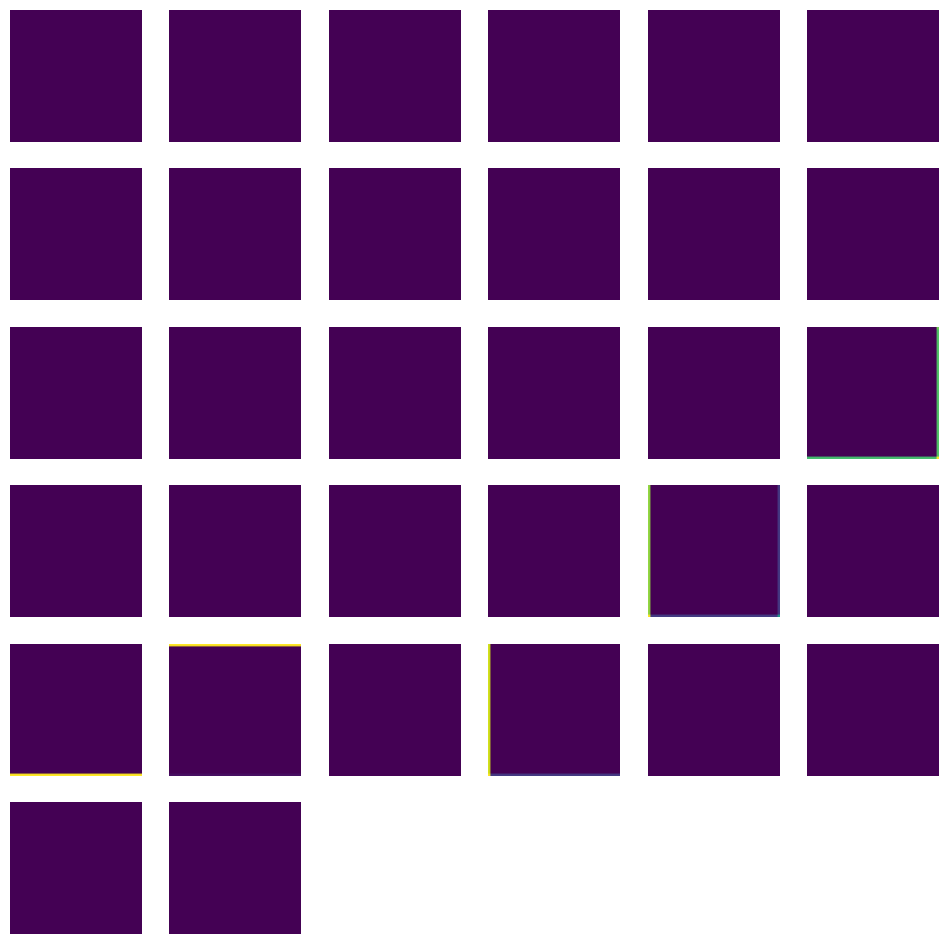

In [133]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import math

def display_conv_layer_features(model, layer_index, img_path):
    """
    Affiche les feature maps d'une couche convolutive choisie par son index.
    
    Args:
        model: le modèle Keras
        layer_index: index de la couche dans model.layers
        img_path: chemin de l'image à visualiser
    """
    # Charger et préparer l'image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = img / 255.0
    input_img = np.expand_dims(img, axis=0)

    # Récupérer la sortie de la couche
    feature_model = Model(inputs=model.inputs, outputs=model.layers[layer_index].output)
    features = feature_model.predict(input_img)
    n_filters = features.shape[3]

    # Affichage
    n = int(math.ceil(np.sqrt(n_filters)))
    plt.figure(figsize=(12,12))
    for i in range(n_filters):
        plt.subplot(n, n, i+1)
        feature = features[0,:,:,i]
        # Normalisation sûre pour éviter les NaN
        feature = (feature - feature.min()) / (feature.max() - feature.min() + 1e-8)
        plt.imshow(feature, cmap='viridis')
        plt.axis('off')
    plt.show()
display_conv_layer_features(model, 10,r"C:\Users\alexi\OneDrive\Bureau\PFE\detection\downsweep\20151001T161504.png")

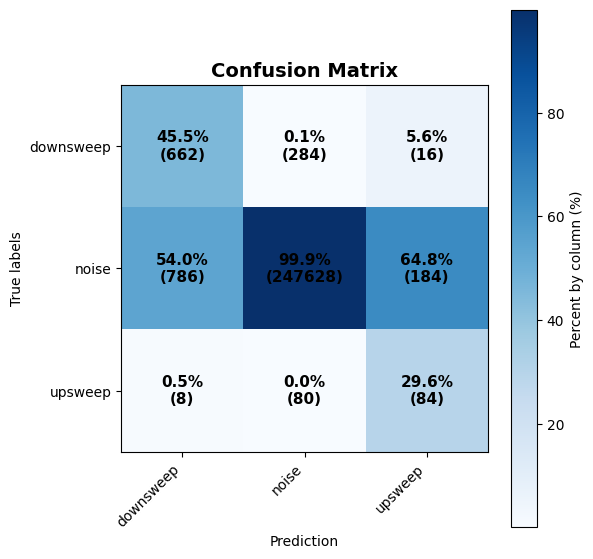

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

# Matrice 3x3 de valeurs
matrix = np.array([
    [662, 284, 16],
    [786, 247628, 184],
    [8, 80, 84]
])

# --- Normalisation par colonne ---
col_sums = matrix.sum(axis=0, keepdims=True)  # somme de chaque colonne
percent_matrix = matrix / col_sums * 100       # pourcentages par colonne

fig, ax = plt.subplots(figsize=(6, 6))

# --- Affichage de la matrice en nuances de bleu ---
norm = Normalize(vmin=percent_matrix.min(), vmax=percent_matrix.max())
im = ax.imshow(percent_matrix, cmap='Blues', norm=norm)

# --- Ajout des pourcentages et valeurs dans chaque case ---
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        percent = percent_matrix[i, j]
        value = matrix[i, j]
        ax.text(j, i, f"{percent:.1f}%\n({value})",
                ha='center', va='center',
                color='black', fontsize=11, fontweight='bold')

# --- Barre de couleur ---
cbar = plt.colorbar(im)
cbar.set_label('Percent by column (%)')

# --- Étiquettes et titres ---
labels = ['downsweep', 'noise', 'upsweep']
ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels)
ax.set_xlabel("Prediction")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [152]:
def split_sweeps(label_name):
    # Ouvre le fichier source
    with open(r"C:\Users\alexi\OneDrive\Bureau\etiquettes_3382\\"+label_name, 'r') as f:
        lines = f.readlines()

    downsweeps = []
    upsweeps = []

    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if not line:
            i += 1
            continue

        # Exemple de ligne : "291.343964   293.849658   downsweep"
        if "downsweep" in line or "upsweep" in line:
            try:
                next_line = lines[i + 1].strip()  # ligne suivante : "\   37.639881   103.011200"
            except IndexError:
                next_line = ""

            # On reconstitue le bloc de deux lignes
            bloc = f"{line}\n{next_line}\n"

            # Classement dans la bonne catégorie
            if "downsweep" in line:
                downsweeps.append(bloc)
            elif "upsweep" in line:
                upsweeps.append(bloc)

            i += 2  # sauter les deux lignes du bloc
        else:
            i += 1

    # Écriture des fichiers
    with open(r"C:\Users\alexi\OneDrive\Bureau\downsweep_label\\"+ label_name, "x") as d:
        d.writelines(downsweeps)

    with open(r"C:\Users\alexi\OneDrive\Bureau\upsweep_label\\"+ label_name, "x") as u:
        u.writelines(upsweeps)




In [153]:
label_path = Path(r"C:\Users\alexi\OneDrive\Bureau\etiquettes_3382")
label_names = [f.name for f in label_path.iterdir() if f.is_file()]
for label_name in label_names : 
    split_sweeps(label_name)

KNN

In [6]:
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [21]:
data_dir = Path(r'C:\Users\alexi\OneDrive\Bureau\PFE\dataset_knn')
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,          # chemin vers ton dossier
    image_size=(171, 51),# redimensionne toutes les images
    batch_size=None     # retourne toutes les images dans un seul tableau
)

# Séparer images et labels (labels inutiles pour clustering)
images = np.array([x.numpy() for x, y in dataset]) / 255.0
print("Images chargées:", images.shape)

# 🔹 Encoder avec ResNet50
model = tf.keras.applications.ResNet50(
    weights='imagenet', include_top=False, pooling='avg', input_shape=(171, 51, 3))
features = model.predict(images, batch_size=32)

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(features)






Found 3638 files belonging to 1 classes.
Images chargées: (3638, 171, 51, 3)
114/114 ━━━━━━━━━━━━━━━━━━━━ 56s 479ms/step


In [23]:
'''
plt.figure(figsize=(12, 60))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(images[i])
    plt.title(f"Cluster {clusters[i]}")
    plt.axis("off")
plt.show()'''

'\nplt.figure(figsize=(12, 60))\nfor i in range(100):\n    plt.subplot(10, 10, i + 1)\n    plt.imshow(images[i])\n    plt.title(f"Cluster {clusters[i]}")\n    plt.axis("off")\nplt.show()'

In [9]:
num_clusters = np.max(clusters) + 1
for c in range(num_clusters):
    cluster_images = images[clusters == c]
    print(f"\nCluster {c}: {len(cluster_images)} images")
    a = 0
    for i, img in enumerate(cluster_images):
        img = (img * 255).astype(np.uint8)
        cv2.imwrite(r'C:\Users\alexi\OneDrive\Bureau\cluster'+str(c)+'\\'+str(a)+".png", img)
        a+=1


Cluster 0: 1689 images

Cluster 1: 531 images

Cluster 2: 1418 images
